In [12]:
import numpy as np

## Part 1

Consider a simple 5 × 5 gridworld problem, described below. This is the simplest abstraction of a reinforcement learning problem that allows us to benchmark and compare various learning algorithms to one another and is known as the ‘gridworld’ environment.

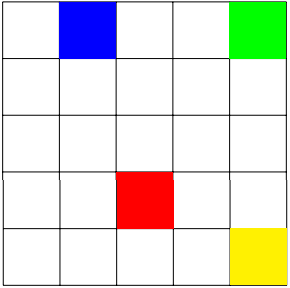

Each of the 25 cells of the gridworld represent a possible state of the world. An agent in the gridworld environment can take a step up, down, left or right. If the agent attempts to step off the grid, the location of the agent remains unchanged.

The blue, green, red and yellow squares represent special states at which the behaviour of the system is as follows. At the blue square, any action yields a reward of 5 and causes the agent to jump to the red square. At the green square, any action yields a reward of 2.5 and causes the agent to jump to either the yellow square or the red square with probability 0.5.

An attempt to step off the grid yields a reward of −0.5 and any move from a white square to another white square yields a reward of 0. Intuitively, an agent with a good policy should try to find the states with a high value, and exploit the rewards available at those states.

1. Consider a reward discount of γ = 0.95 and a policy which simply moves to one of the four directions with equal probability of 0.25. Estimate the value function for each of the states using (1) solving the system of Bellman equations explicitly (2) iterative policy evaluation (3) value iteration. Which states have the highest value? Does this surprise you?

2. Determine the optimal policy for the gridworld problem by (1) explicitly solving the Bellman optimality equation (2) using policy iteration with iterative policy evaluation (3) policy improvement with value iteration.


In [16]:
Grid_size = 5

gridworld = np.zeros((Grid_size, Grid_size)) #Row, Columns

#Blue Square
gridworld[0][1] = 5 #Jump to Red

#Green Square
gridworld[0][4] = 2.5 #Jump to Yellow or Red with probability 0.5

step = np.array([[-1,0],[1,0],[0,-1],[0,1]]) #Up, #Down, #Left, #Right

Yellow_Red = np.array([[4,4],[3,2]])

gamma = 0.95

In [17]:
def Reward_And_Transition(Current_Step, Action):

    if Current_Step == [0,1]:
        Next_Step = [3,2]
        Reward = 5
        return  Next_Step, Reward
    
    elif Current_Step == [0,4]:
        Next_Step = Yellow_Red[np.random.randint(2)]
        Reward = 2.5
        return  Next_Step, Reward

    Next_Step = Current_Step + Action

    if Next_Step[0] < 0 or Next_Step[0] > 4 or Next_Step[1] < 0 or Next_Step[1] > 4:
        Reward = -0.5
        return Current_Step, Reward
    Reward = 0

    return Next_Step, Reward   

#### (2) Iterative Policy Evaluation

In [23]:
Value_Policy = np.zeros((Grid_size, Grid_size))
threshold = 1e-06

In [45]:
while 1:
    delta = 0
    for i in range(Grid_size):
        for j in range(Grid_size):
            Value_Policy_Current = Value_Policy[i,j]
            aux = 0
            #There are 4 directions            
            for k in range(step.shape[0]): 
                New_Step, Reward = Reward_And_Transition([i,j], step[k])
                aux += 0.25 * (Reward + gamma * Value_Policy[New_Step[0], New_Step[1]])
            Value_Policy[i,j] = aux
            delta = max(delta, abs(Value_Policy_Current - aux))
    if delta < threshold:
        break

In [ ]:
Value_Policy